<a href="https://colab.research.google.com/github/stan-dev/example-models/blob/master/jupyter/covid-inf-rate/SantaClara_CmdStanPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Bayesian analysis inference of coronavirus infection rate from the Stanford study in Santa Clara county

This Google Colab Python notebook provides the models and data discussed here:  [Simple Bayesian analysis inference of coronavirus infection rate from the Stanford study in Santa Clara county](https://statmodeling.stat.columbia.edu/2020/05/01/simple-bayesian-analysis-inference-of-coronavirus-infection-rate-from-the-stanford-study-in-santa-clara-county/)

It uses CmdStanPy to compile and fit the model.  


#### First up, a little admin to get the latest CmdStanPy and CmdStan installed on this instance.


In [0]:
# Load packages used in this notebook
import os
import json
import shutil
import urllib.request
import pandas as pd

In [2]:
# Please use the latest version of CmdStanPy
pip install --upgrade cmdstanpy

ERROR: fbprophet 0.6 has requirement cmdstanpy==0.4, but you'll have cmdstanpy 0.9.5 which is incompatible.
  Found existing installation: cmdstanpy 0.4.0
    Uninstalling cmdstanpy-0.4.0:
      Successfully uninstalled cmdstanpy-0.4.0


In [0]:
# Install pre-built CmdStan binary
# (faster than compiling from source via install_cmdstan() function)
tgz_file = 'colab-cmdstan-2.23.0.tar.gz'
tgz_url = 'https://github.com/stan-dev/cmdstan/releases/download/v2.23.0/colab-cmdstan-2.23.0.tar.gz'
if not os.path.exists(tgz_file):
    urllib.request.urlretrieve(tgz_url, tgz_file)
    shutil.unpack_archive(tgz_file)

In [4]:
# Specify CmdStan location via environment variable
os.environ['CMDSTAN'] = './cmdstan-2.23.0'
# Check CmdStan path
from cmdstanpy import CmdStanModel, cmdstan_path
cmdstan_path()

'./cmdstan-2.23.0'

#### Upload models and data from GitHub

The models and data are available on the Stan GitHub repo https://github.com/stan-dev/example-models/tree/master/jupyter/covid-inf-rate

In [7]:
# Upload models and data onto this instance (raw github content files)
urllib.request.urlretrieve('https://raw.githubusercontent.com/stan-dev/example-models/master/jupyter/covid-inf-rate/data/santa_clara_all.data.json', 'santa_clara_all.data.json')
urllib.request.urlretrieve('https://raw.githubusercontent.com/stan-dev/example-models/master/jupyter/covid-inf-rate/data/santa_clara_apr_11.data.json', 'santa_clara_apr_11.data.json')
urllib.request.urlretrieve('https://raw.githubusercontent.com/stan-dev/example-models/master/jupyter/covid-inf-rate/data/santa_clara_apr_27.data.json', 'santa_clara_apr_27.data.json')
urllib.request.urlretrieve('https://raw.githubusercontent.com/stan-dev/example-models/master/jupyter/covid-inf-rate/stan/pool_sens_spec.stan', 'pool_sens_spec.stan')
urllib.request.urlretrieve('https://raw.githubusercontent.com/stan-dev/example-models/master/jupyter/covid-inf-rate/stan/hier_sens_spec.stan', 'hier_sens_spec.stan')
urllib.request.urlretrieve('https://raw.githubusercontent.com/stan-dev/example-models/master/jupyter/covid-inf-rate/stan/hier_sens_spec_offset_mult.stan', 'hier_sens_spec_offset_mult.stan')
!ls
!echo ""
!echo "santa_clara_apr_11.data.json:"
!cat santa_clara_apr_11.data.json

cmdstan-2.23.0			 sample_data
colab-cmdstan-2.23.0.tar.gz	 santa_clara_all.data.json
hier_sens_spec_offset_mult.stan  santa_clara_apr_11.data.json
hier_sens_spec.stan		 santa_clara_apr_27.data.json
pool_sens_spec.stan

santa_clara_apr_11.data.json:
{
    "y_sample" : 50,
    "n_sample" : 3330,
    "y_spec" : 399,
    "n_spec" : 401,
    "y_sens" : 105,
    "n_sens" : 122
}


In the Santa Clara study, of the 3330 people tested (`n_sample`), 50 test results were positive (`y_sample`).  The first version of the paper was released on April 11th, and used specificity data from two studies and sensitivity data from two other studies.

In [8]:
apr_11 = {}
with open('santa_clara_apr_11.data.json') as json_file:
    apr_11 = json.load(json_file)
apr_11

{'n_sample': 3330,
 'n_sens': 122,
 'n_spec': 401,
 'y_sample': 50,
 'y_sens': 105,
 'y_spec': 399}

### Simple Model

The first Stan model in this blogpost is called "santaclara.stan".  It a complete pooling model, therefore we'll call it "pool_sens_spec.stan".

In [9]:
!cat pool_sens_spec.stan

/**
 * meta-analysis over studies of disease infection rate 
 * for variation in sensitivity and specificity
 * pool data from all studies
 */
data {
  int y_sample;
  int n_sample;
  int y_spec;
  int n_spec;
  int y_sens;
  int n_sens;
}
parameters {
  real<lower = 0, upper = 1> p;
  real<lower = 0, upper = 1> spec;
  real<lower = 0, upper = 1> sens;
}
model {
  real p_sample;
  p_sample = p * sens + (1 - p) * (1 - spec);
  y_sample ~ binomial(n_sample, p_sample);
  y_spec ~ binomial(n_spec, spec);
  y_sens ~ binomial(n_sens, sens);
}


We use CmdStanPy to compile and fit the model to the data.

In [10]:
pool_model = CmdStanModel(stan_file='pool_sens_spec.stan')
apr_11_fit = pool_model.sample(data=apr_11)

INFO:cmdstanpy:compiling stan program, exe file: /content/pool_sens_spec
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /content/pool_sens_spec
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4


CmdStanPy reports the central 90% interval, (following McElreath, 2016).  Given the April 11th dataset, this interval is [0.002 - 0.018], thus the data are consistent with an underlying infection rate of between 0 and 2%.

In [11]:
apr_11_fit.summary().round(decimals=3).iloc[1:4,:]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
p,0.010,0.000,0.004,0.002,0.011,0.017,1755.00,11404.0,1.000
spec,0.993,0.000,0.003,0.987,0.994,0.998,1623.10,10546.9,1.000
sens,0.854,0.001,0.031,0.800,0.856,0.901,2008.62,13052.0,1.002


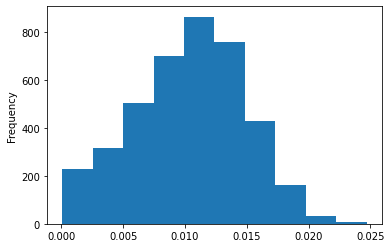

In [12]:
apr_11_drawset = apr_11_fit.get_drawset()
apr_11_drawset.p.plot.hist()

We repeat this procedure with the data from the April 27th version of the study, which has specificity data from 13 studies and sensitivity data from 3 studies.  Again, we pool the results from all studies.

In [13]:
apr_27 = {}
with open('santa_clara_apr_11.data.json') as json_file:
    apr_27 = json.load(json_file)
apr_27

{'n_sample': 3330,
 'n_sens': 122,
 'n_spec': 401,
 'y_sample': 50,
 'y_sens': 105,
 'y_spec': 399}

In [14]:
apr_27_fit = pool_model.sample(data=apr_27)
apr_27_fit.summary().round(decimals=3).iloc[1:4,:]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
p,0.010,0.000,0.004,0.003,0.010,0.017,1469.87,9725.53,1.001
spec,0.993,0.000,0.003,0.987,0.994,0.998,1374.02,9091.35,1.002
sens,0.852,0.001,0.031,0.799,0.854,0.901,1849.13,12235.00,1.000


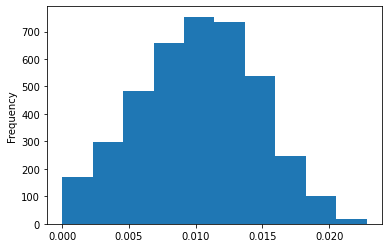

In [15]:
apr_27_drawset = apr_27_fit.get_drawset()
apr_27_drawset.p.plot.hist()

### Hierarchical Model

The hierarchical model allows the sensitivities and specificities to vary across studies.
In the blogpost is called "santaclara_hier.stan".  We'll call it "hier_sens_spec.stan"

In [16]:
!cat hier_sens_spec.stan

/**
 * meta-analysis of disease infection rate studies
 * hierarchical model of sensitivity and specificity
 * non-centered parameterization
 */
data {
  int y_sample;
  int n_sample;
  int J_spec;
  int y_spec [J_spec];
  int n_spec [J_spec];
  int J_sens;
  int y_sens [J_sens];
  int n_sens [J_sens];
}
parameters {
  real<lower = 0, upper = 1> p;
  real mu_spec;
  real<lower = 0> sigma_spec;
  real mu_sens;
  real<lower = 0> sigma_sens;
  vector[J_spec] e_spec;
  vector[J_sens] e_sens;
}
transformed parameters {
  vector[J_spec] spec;
  vector[J_sens] sens;
  spec = inv_logit(mu_spec + sigma_spec * e_spec);
  sens = inv_logit(mu_sens + sigma_sens * e_sens);
}
model {
  real p_sample;
  p_sample = p * sens[1] + (1 - p) * (1 - spec[1]);
  y_sample ~ binomial(n_sample, p_sample);
  y_spec ~ binomial(n_spec, spec);
  y_sens ~ binomial(n_sens, sens);
  e_spec ~ normal(0, 1);
  e_sens ~ normal(0, 1);
  sigma_spec ~ normal(0, 1);
  sigma_sens ~ normal(0, 0.2);
}


__Note__: this model has the suggested tight prior on `sigma_sens` in order to compensate for only having data from 3 studies to fit.

For this model, the data is broken out by study.  We copied this data out of page 19 of the report and munged it into the forms required by the model's data block variable definitions.

In [17]:
hier_data = {}
with open('santa_clara_all.data.json') as json_file:
    hier_data = json.load(json_file)
hier_data

{'J_sens': 4,
 'J_spec': 14,
 'n_sample': 3330,
 'n_sens': [0, 85, 37, 35],
 'n_spec': [0, 371, 30, 70, 1102, 300, 311, 500, 200, 99, 31, 150, 108, 52],
 'y_sample': 50,
 'y_sens': [0, 78, 27, 25],
 'y_spec': [0, 368, 30, 70, 1102, 300, 311, 500, 198, 99, 29, 146, 105, 50]}

In [18]:
hier_model = CmdStanModel(stan_file='hier_sens_spec.stan')
hier_fit = hier_model.sample(data=hier_data)

INFO:cmdstanpy:compiling stan program, exe file: /content/hier_sens_spec
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /content/hier_sens_spec
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4


In [19]:
hier_fit.summary().loc[['p', 'mu_spec', 'sigma_spec', 'mu_sens', 'sigma_sens'],].round(decimals=3)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
p,0.015,0.000,0.005,0.005,0.015,0.022,1360.56,2236.33,1.004
mu_spec,5.753,0.021,0.679,4.748,5.697,6.961,1056.35,1736.31,1.004
sigma_spec,1.698,0.013,0.495,0.979,1.644,2.622,1541.31,2533.44,1.001
mu_sens,1.503,0.005,0.284,1.044,1.503,1.952,2970.97,4883.34,1.000
sigma_sens,0.268,0.003,0.142,0.041,0.265,0.513,1988.68,3268.76,1.001


This central 90% interval is [0.005 - 0.022].

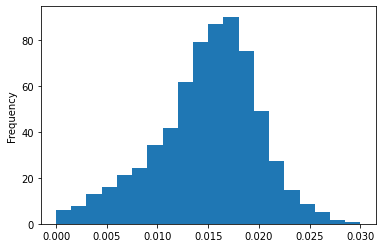

In [20]:
hier_drawset = hier_fit.get_drawset()
hier_drawset.p.plot.hist(bins=20,range=(0.0,0.03),density=True)

Bob Carpenter provided a second version of the hierarchical model in which the parameters for the item-level specificities and sensitivies are specified using the Stan language "offset, multiplier" syntax which allows for affine transforms on real-valued variables.  See the Stan Language Reference Manual, chapter [Univariate Data Types and Variable Declarations](https://mc-stan.org/docs/2_23/reference-manual/univariate-data-types-and-variable-declarations.html) for further details. We call this model "hier_sens_spec_offset_mult.stan"


In [21]:
!cat hier_sens_spec_offset_mult.stan

/**
 * meta-analysis of disease infection rate studies
 * hierarchical model of sensitivity and specificity
 */
data {
  int y_sample;  // for j = 1
  int n_sample;  // for j = 1
  int J_spec;
  int y_spec [J_spec];  // no samples for j > 1
  int n_spec [J_spec];
  int J_sens;
  int y_sens [J_sens];  // no samples for j > 1
  int n_sens [J_sens];
}
parameters {
  real<lower = 0, upper = 1> p;
  real mu_logit_spec;
  real<lower = 0> sigma_logit_spec;
  real mu_logit_sens;
  real<lower = 0> sigma_logit_sens;
  vector<offset = mu_logit_spec, multiplier = sigma_logit_spec>[J_spec] logit_spec;
  vector<offset = mu_logit_sens, multiplier = sigma_logit_sens>[J_sens] logit_sens;
}
transformed parameters {
  vector<lower = 0, upper = 1>[J_spec] spec = inv_logit(logit_spec);
  vector<lower = 0, upper = 1>[J_sens] sens = inv_logit(logit_sens);
}
model {
  real p_sample = p * sens[1] + (1 - p) * (1 - spec[1]);  // j = 1
  y_sample ~ binomial(n_sample, p_sample);                // j = 1
  y_spec ~ 

In [22]:
hier_model_v2 = CmdStanModel(stan_file='hier_sens_spec_offset_mult.stan')
hier_fit_v2 = hier_model_v2.sample(data=hier_data)
hier_fit_v2.summary().loc[['p', 'mu_logit_spec', 'sigma_logit_spec', 'mu_logit_sens', 'sigma_logit_sens'],].round(decimals=3)

INFO:cmdstanpy:compiling stan program, exe file: /content/hier_sens_spec_offset_mult
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /content/hier_sens_spec_offset_mult
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
p,0.014,0.000,0.006,0.003,0.015,0.022,395.382,456.989,1.006
mu_logit_spec,5.725,0.017,0.654,4.789,5.647,6.937,1412.200,1632.240,1.001
sigma_logit_spec,1.705,0.016,0.490,0.984,1.659,2.603,945.136,1092.400,1.005
mu_logit_sens,1.494,0.006,0.284,1.013,1.505,1.949,2286.670,2642.970,1.001
sigma_logit_sens,0.272,0.003,0.143,0.041,0.269,0.508,1920.740,2220.020,1.000


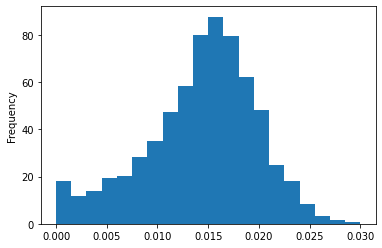

In [23]:
hier_drawset_v2 = hier_fit_v2.get_drawset()
hier_drawset_v2.p.plot.hist(bins=20,range=(0.0,0.03),density=True)